In [1]:
! git clone https://github.com/shane200195/Stock_ml.git

Cloning into 'Stock_ml'...
remote: Enumerating objects: 555, done.
remote: Counting objects: 100% (555/555), done.
remote: Compressing objects: 100% (551/551), done.
remote: Total 555 (delta 6), reused 553 (delta 4), pack-reused 0
Receiving objects: 100% (555/555), 16.83 MiB | 24.07 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
! ls

sample_data  Stock_ml


In [92]:
import pandas as pd
import numpy as np

djia = pd.read_csv("Stock_ml/dija.csv")
djia = djia.set_index("Date")


for column in dija.columns:
  djia[column + "Volatile?"] = [1 if abs(i) > 0.01 else 0 for i in djia[column]]

# feature selection
target = "MSFT"
features = [i for i in djia.columns if "Volatile?" in i and target not in i]

x = djia.loc[:,features].values
#selecting the target that will be used to classify a particular state
result = djia[target + "Volatile?"].values
print(result)

[1 0 0 ... 0 0 0]


In [93]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

print(principal_components)

[[ 1.62811025 -0.35984061]
 [ 0.72363746  0.55227948]
 [-0.25724386 -1.28786243]
 ...
 [-2.59315692  0.46385426]
 [-2.59315692  0.46385426]
 [-1.28613806  0.33788401]]


In [94]:
principalDf = pd.DataFrame(data = principal_components
             , columns = ['component 1', 'component 2'])

# converting the index of result
result = pd.DataFrame(data = result, columns=["Result"])
finalDf = pd.concat([principalDf, result], axis = 1)
print(finalDf)

      component 1  component 2  Result
0        1.628110    -0.359841       1
1        0.723637     0.552279       0
2       -0.257244    -1.287862       0
3       -0.472727    -0.664925       0
4        0.265602     1.023791       0
...           ...          ...     ...
3014    -2.057057     0.787310       0
3015    -2.168073     0.035465       0
3016    -2.593157     0.463854       0
3017    -2.593157     0.463854       0
3018    -1.286138     0.337884       0

[3019 rows x 3 columns]


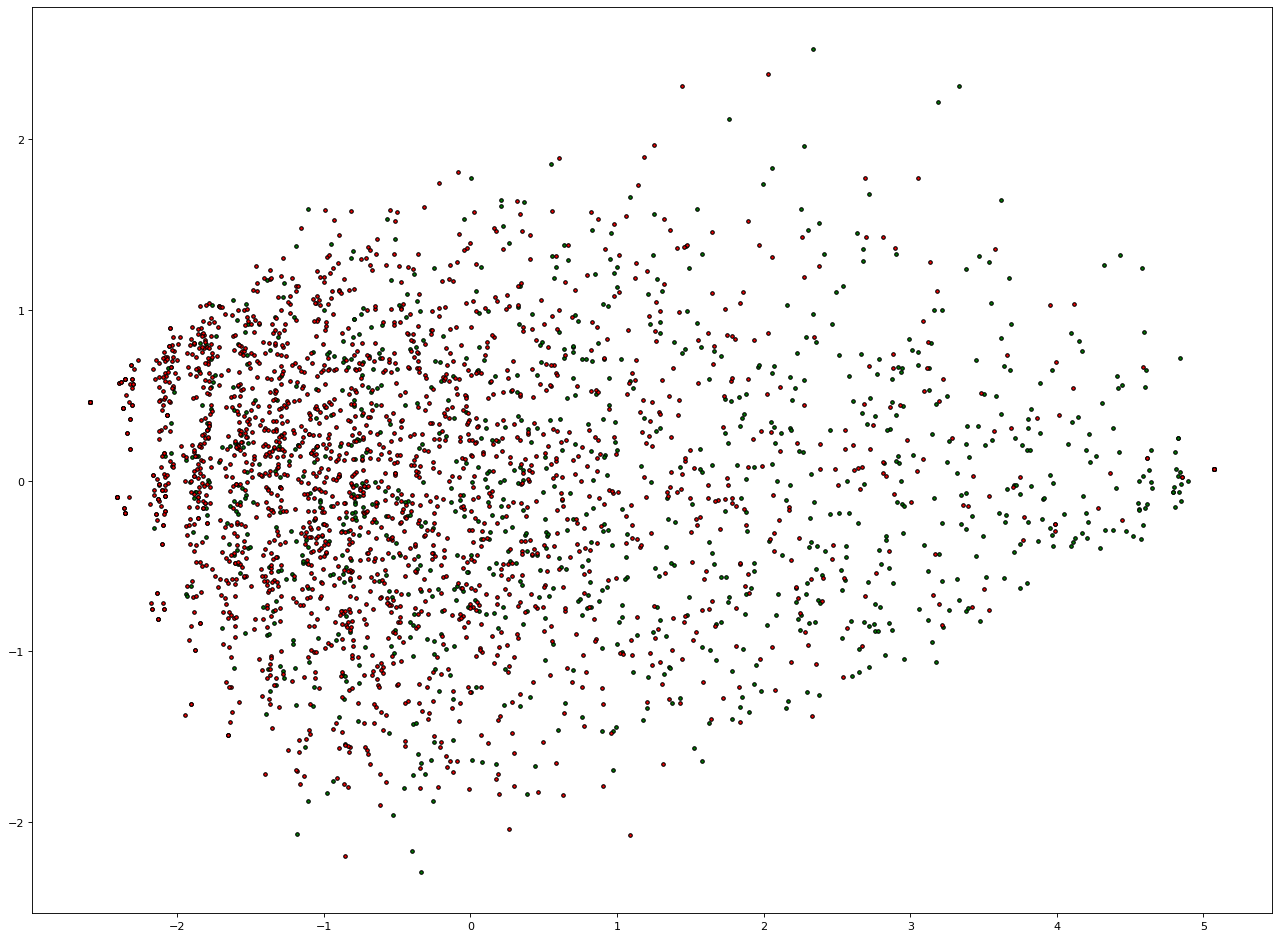

In [95]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')
targets = [1, 0]
colors = ['g', 'r']
for target, color in zip(targets, colors):
  indicesToKeep = finalDf["Result"] == target
  plt.scatter(finalDf.loc[indicesToKeep, 'component 1']
               , finalDf.loc[indicesToKeep, 'component 2']
               , c = color
               , s = 10, edgecolor="k")
# plt.scatter(principalDf["component 1"], principalDf["component 2"])
plt.show()


Training SVM model for S&P500 dataset

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

SVM_djia = SVC(gamma="auto")
X_train, X_test, y_train, y_test = train_test_split(x, result, test_size=0.5, random_state=42)

SVM_djia.fit(X_train, y_train)

print(SVM_djia.score(X_train, y_train))
print(SVM_djia.score(X_test, y_test))





/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7375745526838966
0.7350993377483444


Training a KNN model for S&P500 dataset

In [100]:
from sklearn.neighbors import KNeighborsClassifier

KNN_djia = KNeighborsClassifier(n_neighbors=10)
KNN_djia.fit(X_train, y_train)
#predictions = KNN_sp500.predict(X_test)
#accuracy_score(predictions, y_test)
print(KNN_djia.score(X_train, y_train))
print(KNN_djia.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


0.7263088137839628
0.7311258278145696


Logistic Regression for S&P500 dataset

In [101]:
from sklearn.linear_model import LogisticRegression

LR_djia = LogisticRegression()
LR_djia.fit(X_train, y_train)

print(LR_djia.score(X_train, y_train))
print(LR_djia.score(X_test, y_test))

0.7335984095427436
0.7258278145695364


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
